# Recap from our last churn prediction code

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [248]:
df = pd.read_csv('Telcos_Cus_Churn.csv')
 
df.columns = df.columns.str.lower().str.replace(' ', '_')
 
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
 
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
 
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)
 
df.churn = (df.churn == 'yes').astype(int)

In [249]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
 
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values
 
del df_train['churn']
del df_val['churn']
del df_test['churn'] 

In [250]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
 
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [251]:
dv = DictVectorizer(sparse=False)
 
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
 
model = LogisticRegression()
model.fit(X_train, y_train)

/Users/olaoluwatunmise/miniconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [252]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
 
y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()
 
# Output: 0.8034066713981547

0.8019872249822569

# Accuracy and Dummy Model

In [253]:
len(y_val)

1409

In [254]:
(y_val == churn_decision).mean()

0.8019872249822569

In [255]:
1132/1409

0.8034066713981547

In [256]:
from sklearn.metrics import accuracy_score

In [257]:
accuracy_score(y_val, y_pred >= 0.5)

0.8019872249822569

In [258]:
threshold = np.linspace(0, 1, 21)

scores = []

for t in threshold:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' %(t, score))
    scores.append(score)

0.00 0.274
0.05 0.505
0.10 0.591
0.15 0.665
0.20 0.709
0.25 0.740
0.30 0.762
0.35 0.770
0.40 0.786
0.45 0.793
0.50 0.802
0.55 0.801
0.60 0.796
0.65 0.784
0.70 0.764
0.75 0.744
0.80 0.732
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


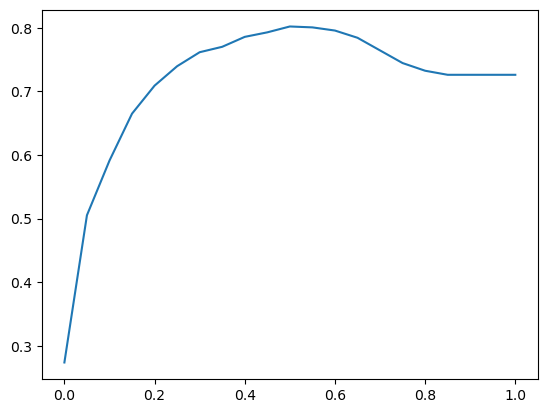

In [259]:
plt.plot(threshold, scores)

In [260]:
from collections import Counter

In [261]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [262]:
1 - y_val.mean()

0.7260468417317246

# Confusion Table

In [263]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [264]:

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)


In [265]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [266]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [267]:
confustion_matrix = np.array([
        [tn, fp],
        [fn, tp]

])
confustion_matrix

array([[920, 103],
       [176, 210]])

In [268]:
(confustion_matrix / confustion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

# Precision and Recall

In [269]:
(tp + tn) / (tp + tn +fp + fn)

0.8019872249822569

In [270]:
p = tp / (tp + fp)
p

0.670926517571885

In [271]:
tp

210

In [272]:
tp + fp

313

In [273]:
r = tp / (tp + fn)
r

0.5440414507772021

In [274]:
tp + fn

386

# ROC Curves

In [275]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [276]:
fpr = fp / (fp + tn)
fpr

0.10068426197458455

In [277]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [278]:
columns = [ 'threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [279]:
df_scores['tpr' ] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [280]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,357,53,666,0.862694,0.348974
30,0.3,287,237,99,786,0.743523,0.231672
40,0.4,249,165,137,858,0.645078,0.161290
50,0.5,210,103,176,920,0.544041,0.100684
60,0.6,150,52,236,971,0.388601,0.050831
70,0.7,73,19,313,1004,0.189119,0.018573
80,0.8,10,1,376,1022,0.025907,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


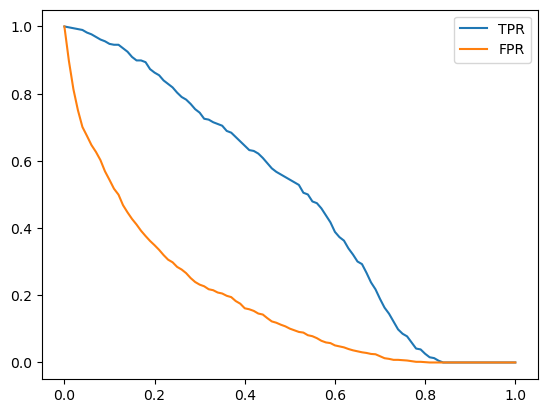

In [281]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

In [282]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [283]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [284]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = [ 'threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr' ] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [285]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [286]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


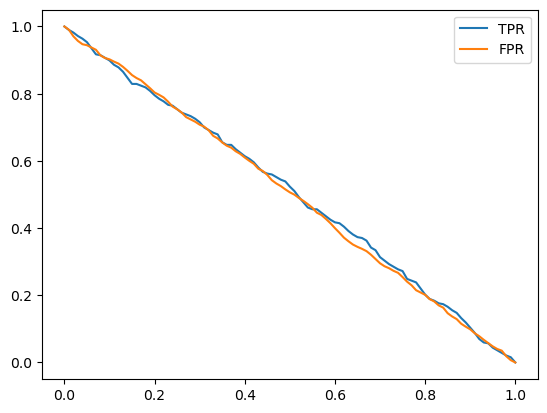

In [287]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

# Ideal Model

In [288]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [289]:
y_ideal = np.repeat([0,1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [290]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [291]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [292]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


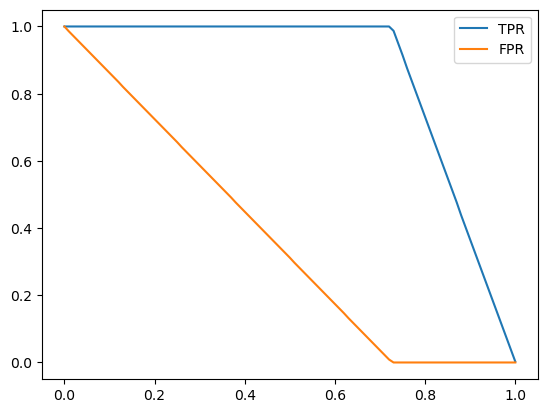

In [293]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

# Pulling Everything Together

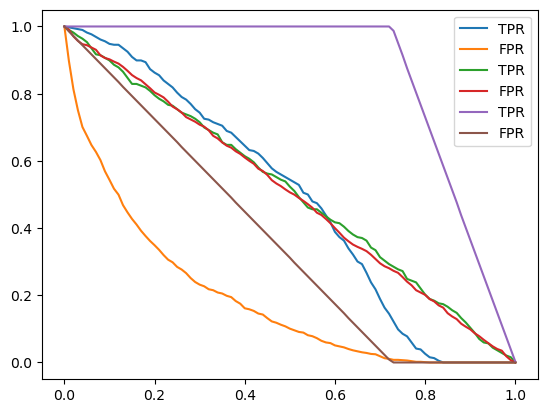

In [294]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')

plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')

plt.legend()

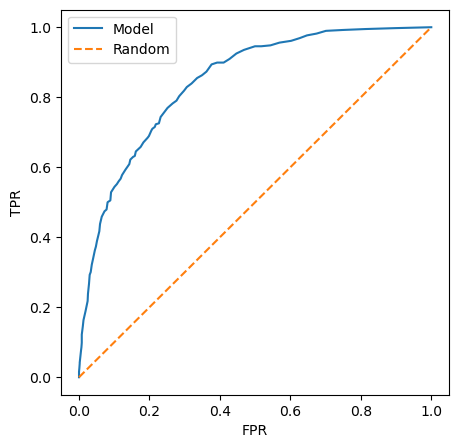

In [295]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [296]:
# Using Ski-Learn

from sklearn.metrics import roc_curve

In [297]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

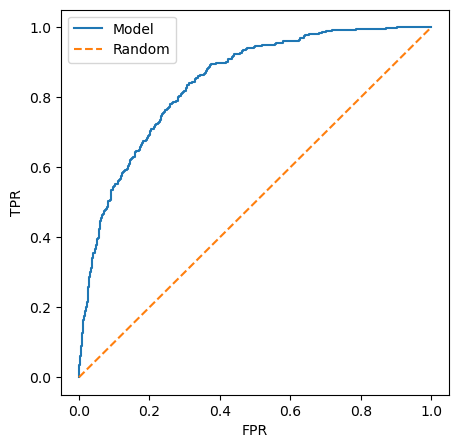

In [298]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')


plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

# ROC AUC

In [299]:
from sklearn.metrics import auc

In [300]:
auc(fpr, tpr)

0.8436377817958964

In [301]:
auc(df_scores.fpr, df_scores.tpr)

0.8438302463039217

In [302]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [303]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(df_scores.fpr, df_scores.tpr)

0.8438302463039217

In [304]:
from sklearn.metrics import roc_auc_score

In [305]:
roc_auc_score(y_val,y_pred)

0.8436377817958964

In [306]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [307]:
import random

In [308]:
n = 1000000
success = 0

for i in range(n):
    pos_ind = random.randint(0,len(pos) - 1)
    neg_ind = random.randint(0,len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n 

0.843268

In [315]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0,len(pos), size=n)
neg_ind = np.random.randint(0,len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.8461